# ARIMA

Esto es para la instalación de AUTOARIMA

In [97]:
# pip install pmdarima

In [98]:
import warnings
warnings.filterwarnings(action="ignore")

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
%matplotlib inline
import requests
import csv

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from math import sqrt

import plotly.express as px

In [99]:
# CSV_URL_LISTING = 'https://www.alphavantage.co/query?function=LISTING_STATUS&apikey=WOVNUEXRHX1P3Q98'


# with requests.Session() as s:
#     download = s.get(CSV_URL_LISTING)
#     decoded_content = download.content.decode('utf-8')
#     cr = csv.reader(decoded_content.splitlines(), delimiter=',')
#     my_list = list(cr)

# listing = pd.DataFrame(my_list, columns=("symbol", "name", "exchange", "assetType", "ipoDate", "delistingDate", "status"))
# listing.drop(listing.index[0], inplace=True)
# listing

Si no funciona el código anterior, descargar listado con el siguiente código:

In [100]:
listing = pd.read_csv("../z.TFM/listing_status.csv")
listing

,symbol,name,exchange,assetType,ipoDate,delistingDate,status
0,A,Agilent Technologies Inc,NYSE,Stock,1999-11-18,NaN,Active
1,AA,Alcoa Corp,NYSE,Stock,2016-10-18,NaN,Active
2,AAA,AAF First Priority CLO Bond ETF,NYSE ARCA,ETF,2020-09-09,NaN,Active
3,AAAU,Goldman Sachs Physical Gold ETF,NYSE ARCA,ETF,2018-08-15,NaN,Active
4,AAC,Ares Acquisition Corporation - Class A,NYSE,Stock,2021-03-25,NaN,Active
...,...,...,...,...,...,...,...
12240,ZYME,Zymeworks Inc,NYSE,Stock,2017-04-28,NaN,Active
12241,ZYNE,Zynerba Pharmaceuticals Inc,NASDAQ,Stock,2015-08-05,NaN,Active
12242,ZYXI,Zynex Inc,NASDAQ,Stock,2012-07-23,NaN,Active
12243,ZZK,NaN,NYSE ARCA,Stock,2020-07-22,NaN,Active


In [101]:
listing[listing['symbol']=='TSLA']

,symbol,name,exchange,assetType,ipoDate,delistingDate,status
11019,TSLA,Tesla Inc,NASDAQ,Stock,2010-06-29,NaN,Active


### DESCARGA DE DATOS Y PREPROCESADO

In [102]:
symbol = "TSLA"


year = [1,2]
month = [1,2,3,4,5,6,7,8,9,10,11,12]
real = pd.DataFrame()
     
for y in range(2):
    for m in range(12):
        URL= 'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY_EXTENDED&symbol='+symbol+'&interval=60min&slice=year'+str(year[y])+'month'+str(month[m])+'&apikey=UHV76ERHZOBH4LU8'
        
        with requests.Session() as s:
            download = s.get(URL)
            decoded_content = download.content.decode('utf-8')
            cr = csv.reader(decoded_content.splitlines(), delimiter=',')
            my_list = list(cr)
            
            aux = pd.DataFrame(my_list, columns=("time", "open", "high", "low", "close", "volume"))
            aux.drop(aux.index[0], inplace=True)
            real = real.append(aux, ignore_index=True)

real.sort_values("time", ascending=True, inplace=True)
real["time"] = pd.to_datetime(real["time"])
real["close"] = pd.to_numeric(real["close"])
real = real[["time", "close"]]
real.reset_index(drop=True, inplace=True)


In [103]:
real

,time,close
0,2020-04-13 05:00:00,115.7500
1,2020-04-13 06:00:00,116.5000
2,2020-04-13 07:00:00,116.6040
3,2020-04-13 08:00:00,118.6000
4,2020-04-13 09:00:00,118.2220
...,...,...
7951,2022-04-01 16:00:00,1084.5600
7952,2022-04-01 17:00:00,1087.4300
7953,2022-04-01 18:00:00,1090.9988
7954,2022-04-01 19:00:00,1091.4900


In [104]:
real = real.dropna().reset_index()

In [105]:
real

,index,time,close
0,0,2020-04-13 05:00:00,115.7500
1,1,2020-04-13 06:00:00,116.5000
2,2,2020-04-13 07:00:00,116.6040
3,3,2020-04-13 08:00:00,118.6000
4,4,2020-04-13 09:00:00,118.2220
...,...,...,...
7951,7951,2022-04-01 16:00:00,1084.5600
7952,7952,2022-04-01 17:00:00,1087.4300
7953,7953,2022-04-01 18:00:00,1090.9988
7954,7954,2022-04-01 19:00:00,1091.4900


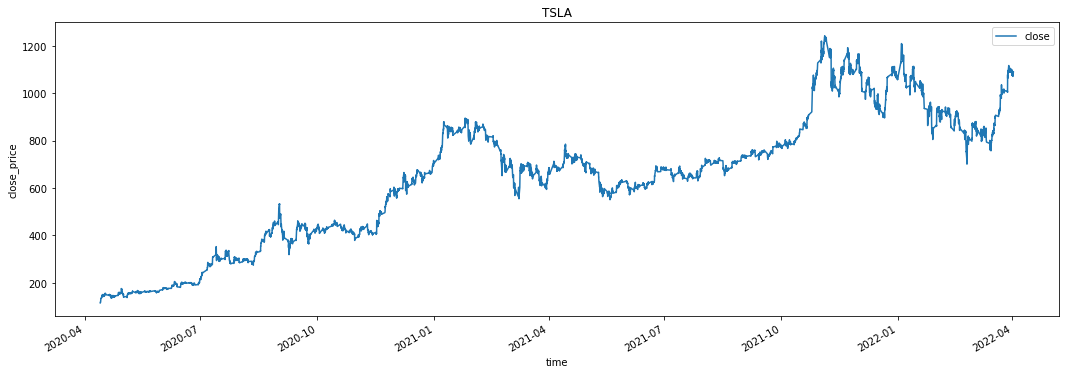

In [106]:
ax = real.plot("time", "close",figsize=(18,6), title=symbol); 
ax.set_xlabel("time");
ax.set_ylabel("close_price");


### DESCOMPOSICIÓN


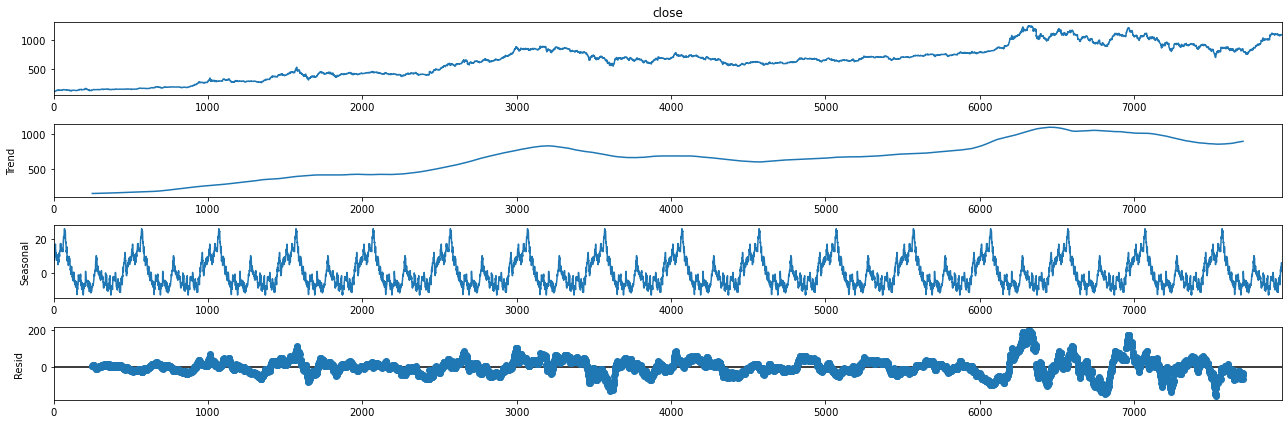

In [107]:
additive = seasonal_decompose(real['close'], model='additive', freq=500)

with plt.rc_context():
    plt.rc("figure", figsize=(18,6))
    additive.plot()
    plt.show()


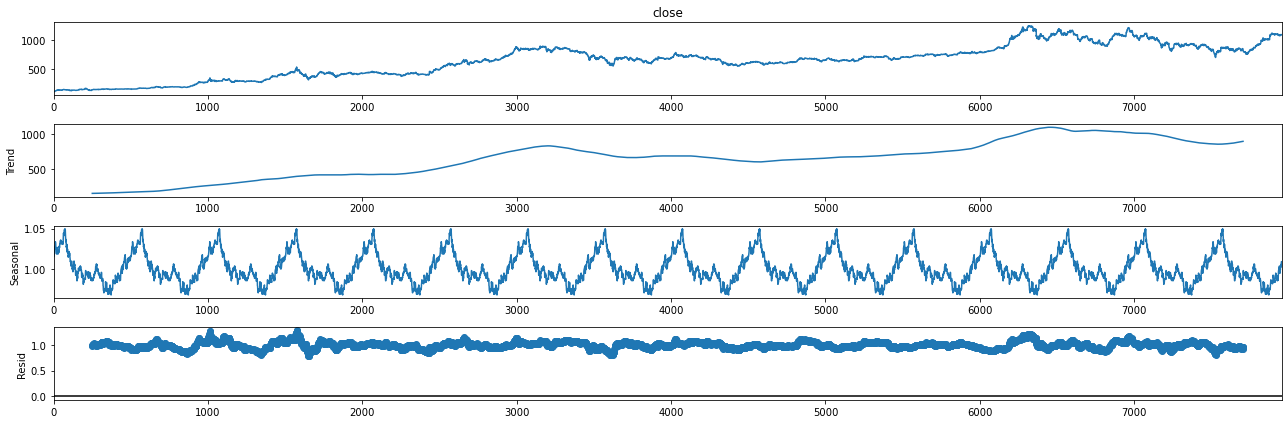

In [108]:
additive = seasonal_decompose(real['close'], model='multiplicative', freq=500)

with plt.rc_context():
    plt.rc("figure", figsize=(18,6))
    additive.plot()
    plt.show()

### AUTOCORRELACIÓN

##### Función de autocorrelación (ACF)

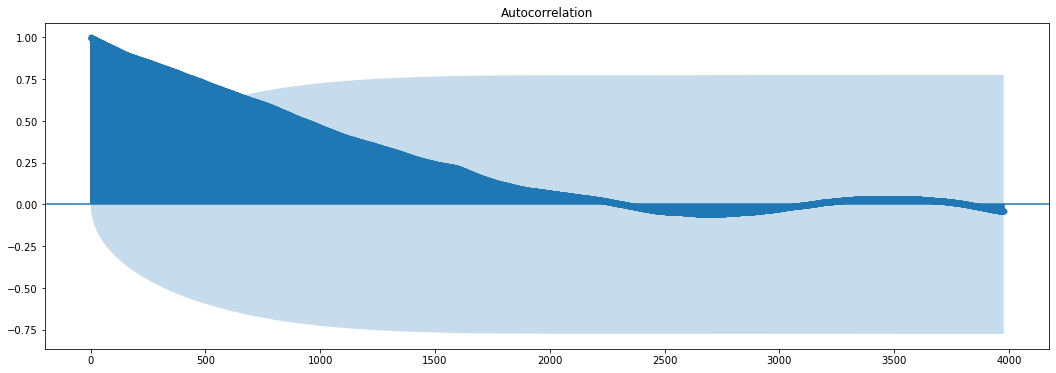

In [109]:
with plt.rc_context():
    plt.rc("figure", figsize=(18,6))
    plot_acf(real['close'], lags=np.round(len(real['close'])/2)-1);

##### Función de autocorrelación parcial (PACF)

In [110]:
# with plt.rc_context():
#     plt.rc("figure", figsize=(18,6))
#     plot_pacf(real['close'], lags=np.round(len(real['close'])/2)-1);

### TEST DICKEY FULLER AUMENTADO

Para poder llevar a cabo buenas predicciones en series temporales, necesitamos que haya **estacionariedad**

Para que haya **estacionariedad** necesitamos que:

 - La serie sea no estacional
 - No haya heterocedasticidad (es decir, que la varianza de la serie sea constante a lo largo del tiempo)
 - No haya autocorrelación (es decir, que las covarianzas de la serie son independientes del tiempo, sólo dependen del desfase entre ellas)
 
Para comprobar la estacienariedad se realiza el test de **Dickey Fuller Aumentado**:

 - H0: la serie temporal no es estacionaria
 - H1: la serie temporal es estacionaria
 
Si el **p-valor** de la salida es inferior a los niveles de significación habituales (alfa = 0.05), entonces podemos rechazar la hipótesis nula y concluir que la serie es estacionaria.

In [111]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(real['close'])
print("The p-value: ", adf_test[1])

The p-value:  0.6317502048608873


In [112]:
adf_test[1]

0.6317502048608873

### AUTOARIMA

In [113]:
import pmdarima as pm

# Coefficients
auto_arima = pm.auto_arima(real['close'], seasonal=False, m=0) #m es el componente estacional
trend_order = auto_arima.order

print('ARIMA COEFFICIENTS:\n')
print('AR (p): ' + str(auto_arima.order[0]))
print('I (d): ' + str(auto_arima.order[1]))
print('MA (q): ' + str(auto_arima.order[2]))

ARIMA COEFFICIENTS:

AR (p): 3
I (d): 1
MA (q): 3


### SEPARACIÓN ENTRE TRAIN Y TEST

In [114]:
TEST_SIZE = 0.2

train = real[:(int(len(real)*(1-TEST_SIZE)))]
test = real[(int(len(real)*(1-TEST_SIZE))):]


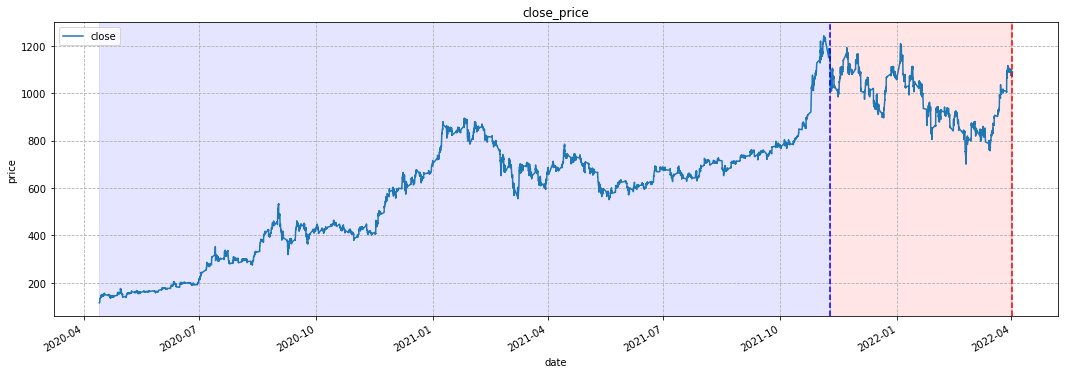

In [115]:

# Visualización
ax = real.plot("time", "close",figsize=(18,6), title='close_price');  

init__limit = real["time"][0]  
train_limit = real["time"][len(train)-1] 
test__limit = real["time"][len(train)+len(test)-1] 

ax.axvline(train_limit, linestyle='--', color='blue')
ax.axvline(test__limit, linestyle='--', color='red')

ax.axvspan(init__limit, train_limit, alpha=0.1, color='blue')
ax.axvspan(train_limit, test__limit, alpha=0.1, color='red')

# ax.text(real["time"][int((len(train)-1)*0.5)], 610, 'Train set', fontsize=18)
# ax.text(real["time"][int(len(train)+(len(test)-1)*0.3)], 610, 'Test set', fontsize=18)

ax.grid(linestyle='--')

ax.set_xlabel("date");
ax.set_ylabel("price");

In [116]:
Metrics = pd.DataFrame(columns=['Model', 'R2'])

### Naive Forecast

No handles with labels found to put in legend.


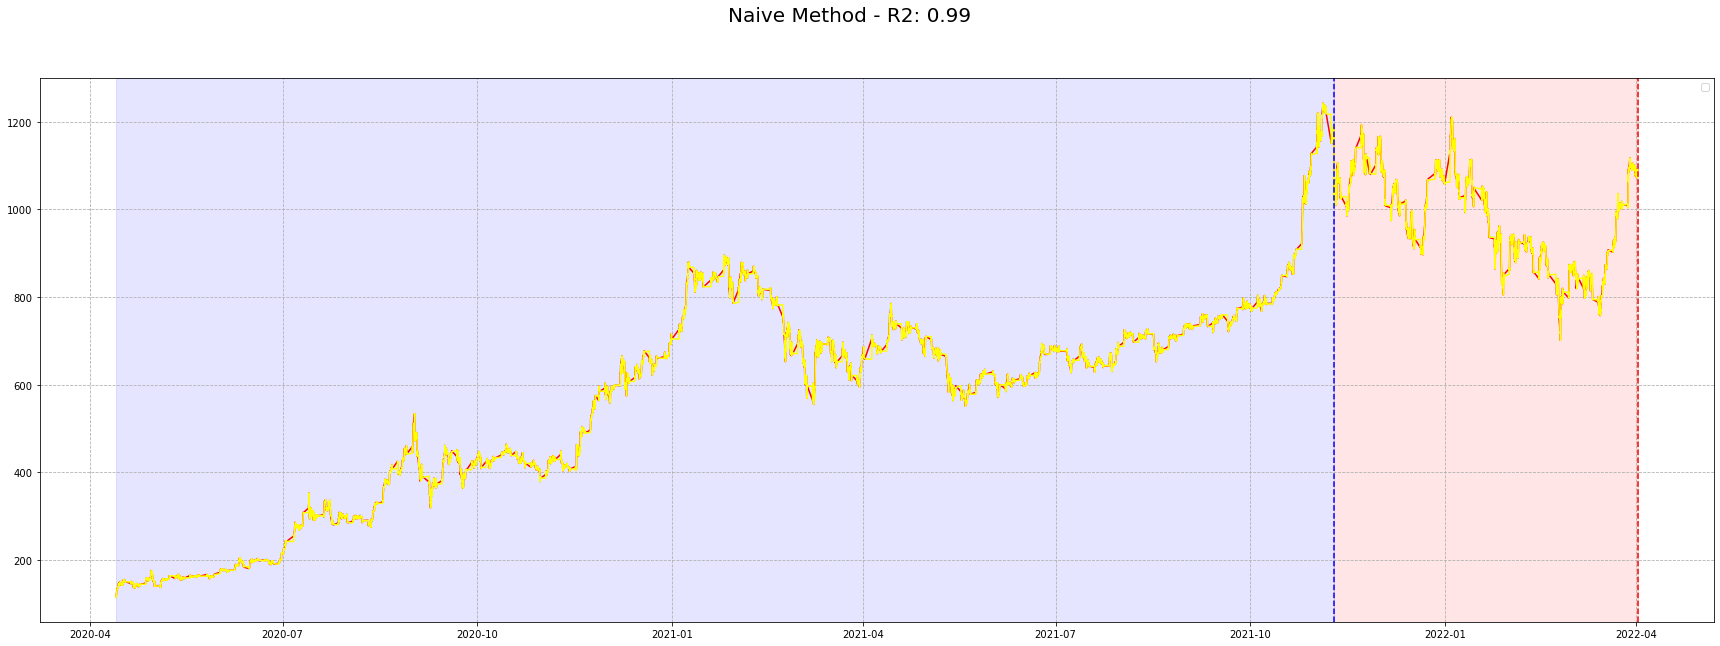

In [117]:
# Model
MODEL = 'Naive Method'

# Training model
fitted_train = train.shift(periods=1)

# Get Test Set Predictions
predict_test = test.shift(periods=1)

# Get RMSE from Test Set
real_values = test['close'][1:]
pred_values = predict_test['close'][1:]
r2 = r2_score(real_values, pred_values)

# Get predictions from whole set
predictions = real.shift(periods=1)

# Preparing data to plot
real_plot = real['close']
pred_plot = predictions['close']

# Visualization
fig, ax = plt.subplots(figsize=(30, 10))


ax.plot(real["time"][1:], real_plot[1:], color="red")
ax.plot(real["time"][1:], pred_plot[1:], color="yellow")

plt.suptitle(MODEL + ' - R2: ' + str(np.round(r2, 3)), fontsize=20)
plt.legend();

plt.axvline(train_limit, linestyle='--', color='blue');
plt.axvline(test__limit, linestyle='--', color='red');

plt.axvspan(init__limit, train_limit, alpha=0.1, color='blue');
plt.axvspan(train_limit, test__limit, alpha=0.1, color='red');

plt.grid(linestyle='--')

metric_data = {'Model':MODEL, 'R2':np.round(r2, 3)}
Metrics = Metrics.append(metric_data, ignore_index=True)




### Probando con AUTOARIMA

In [118]:
# Coefficients
p=auto_arima.order[0]
d=auto_arima.order[1]
q=auto_arima.order[2]

# Model
MODEL = 'ARIMA Process ('+str(p)+','+str(d)+','+str(q)+')'
MODEL

'ARIMA Process (3,1,3)'

No handles with labels found to put in legend.


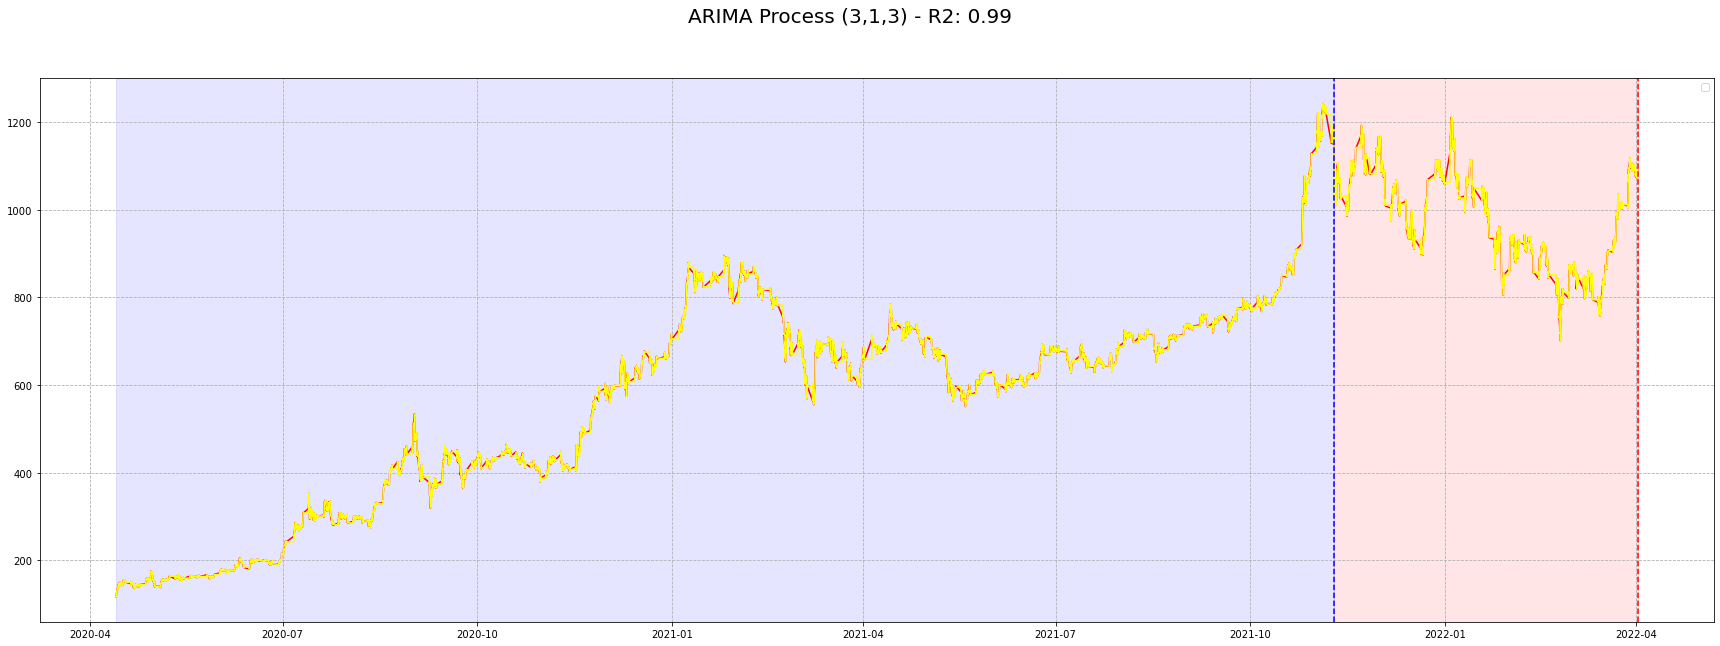

In [126]:
# Applying log
real_log = np.log(real["close"])
train_log = np.log(train["close"])
test_log = np.log(test["close"])

# Training model
model = ARIMA(train_log, order=(p, d, q))
fitted_model = model.fit()
fitted_train = fitted_model.fittedvalues

#Get Test Set Predictions
predict_test = fitted_model.predict(test_log.index[0], test_log.index[len(test_log)-1])

 # Reverting from differencing
fitted_train = fitted_train + train_log.shift(periods=d)
predict_test = predict_test + test_log.shift(periods=d)

# Get normal scale
fitted_train = np.exp(fitted_train)
predict_test = np.exp(predict_test)

# Get R2 from Test Set
real_values = test['close'][d:]
pred_values = predict_test[d:]
r2 = r2_score(real_values, pred_values)

# Get predictions from whole set
predictions = fitted_model.predict(real[d:].index[0], real[d:].index[len(real[d:])-1])

# Reverting from differencing
predictions = predictions +  real_log[d:].shift(periods=d)

# Get normal scale
predictions = np.exp(predictions)

#Preparing data to plot
real_plot = real['close'][d:]
pred_plot = predictions

# Visualization


fig, ax = plt.subplots(figsize=(30, 10))


ax.plot(real["time"][1:], real_plot, color="red")
ax.plot(real["time"][1:], pred_plot, color="yellow")


plt.suptitle(MODEL + ' - R2: ' + str(np.round(r2, 3)), fontsize=20)
plt.legend();

plt.axvline(train_limit, linestyle='--', color='blue');
plt.axvline(test__limit, linestyle='--', color='red');

plt.axvspan(init__limit, train_limit, alpha=0.1, color='blue');
plt.axvspan(train_limit, test__limit, alpha=0.1, color='red');

plt.grid(linestyle='--')

metric_data = {'Model':MODEL, 'R2':np.round(r2, 3)}
Metrics = Metrics.append(metric_data, ignore_index=True)

# SCORES

In [120]:
Metrics.sort_values(by=["R2"], ascending=True)

,Model,R2
0,Naive Method,0.99


# GRÁFICA CON ZOOM

Preparamos los datos para poder hacer una gráfica en la que podamos hacer zoom para ver el lageado de la serie predicha respecto a la serie real

In [121]:
R2_test = r2_score(real_values, pred_values)
                    

In [122]:
predictions

,index,time,close
0,NaN,NaT,NaN
1,0.0,2020-04-13 05:00:00,115.7500
2,1.0,2020-04-13 06:00:00,116.5000
3,2.0,2020-04-13 07:00:00,116.6040
4,3.0,2020-04-13 08:00:00,118.6000
...,...,...,...
7951,7950.0,2022-04-01 15:00:00,1079.9250
7952,7951.0,2022-04-01 16:00:00,1084.5600
7953,7952.0,2022-04-01 17:00:00,1087.4300
7954,7953.0,2022-04-01 18:00:00,1090.9988


In [123]:
real

,index,time,close
0,0,2020-04-13 05:00:00,115.7500
1,1,2020-04-13 06:00:00,116.5000
2,2,2020-04-13 07:00:00,116.6040
3,3,2020-04-13 08:00:00,118.6000
4,4,2020-04-13 09:00:00,118.2220
...,...,...,...
7951,7951,2022-04-01 16:00:00,1084.5600
7952,7952,2022-04-01 17:00:00,1087.4300
7953,7953,2022-04-01 18:00:00,1090.9988
7954,7954,2022-04-01 19:00:00,1091.4900


In [124]:
real

,index,time,close
0,0,2020-04-13 05:00:00,115.7500
1,1,2020-04-13 06:00:00,116.5000
2,2,2020-04-13 07:00:00,116.6040
3,3,2020-04-13 08:00:00,118.6000
4,4,2020-04-13 09:00:00,118.2220
...,...,...,...
7951,7951,2022-04-01 16:00:00,1084.5600
7952,7952,2022-04-01 17:00:00,1087.4300
7953,7953,2022-04-01 18:00:00,1090.9988
7954,7954,2022-04-01 19:00:00,1091.4900


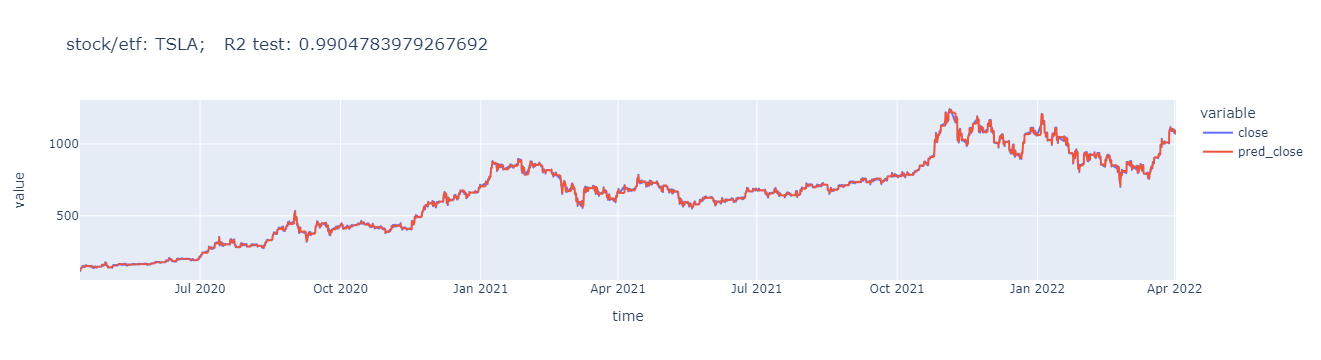

In [127]:

real['pred_close'] = predictions

fig = px.line(real, x="time", y=["close", "pred_close"], title = 'stock/etf: '+ symbol + ';   R2 test: '+str(R2_test))

fig

# SERIALIZAR EL MODELO

modelo a guardar

In [128]:
fitted_model

guardamos el modelo

In [ ]:
# pickle.dump(fitted_model, open('ARIMA_model.pkl', 'wb'))

cargamos el modelo

In [129]:
import pickle

new_model = pickle.load(open('ARIMA_model.pkl', 'rb'))

In [131]:
# new_predictions = new_model.predict(1091)



1091   NaN
1092   NaN
1093   NaN
1094   NaN
1095   NaN
        ..
7951   NaN
7952   NaN
7953   NaN
7954   NaN
7955   NaN
Length: 3937, dtype: float64